In [1]:
import pandas as pd
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import scipy.stats as stats
from scipy.stats import bootstrap
warnings.filterwarnings('ignore')

RAND=10

# 1. Успешность прототипа

1 вариант - Если наши предыдущие 200 вариантов полностью разные, в т.ч. каких не было у конкурентов, и это не доработки, а независимые друг от друга прототипы, разрабатываются как эксперимент. В этом случае вероятность успеха 1/2, т.к. это взаимосиключающие независимые события.<br>
2 вариант - если 201-й разрабатывался по проекту, который учитывает недостатки всех неуспешных, а не просто "другой", как в п.1., или мы знаем, что прототип должен быть успешным, например, есть целевая аудитория, которая ждёт, проводили опросы, анализ спроса, или это заказ на заранее упешный продукт, и т.д., то вероятность успеха близка к 1. Но насколько прототип будет успешный, сказать нельзя, т.к. успех/неуспех не произошли. <br>
3 вариант - если 201-й прототип аналогичен успешным прототипам конкурентов, то вероятность успеха аналогична успеху конкурентов и = 401/402 (количество исходов = 1 - 1/201*2 = 401/402).<br>

# 2. Сравнение групп платящих игроков

2.1. Опишите оптимальный по вашему мнению дизайн эксперимента

Необходимо провести А/Б тестирование.<br>
<b>1. Определить цель, метрику.</b><br>
Для чего мы внедряем обновление? Предложить ожидаемый измеримый результат.<br> Цель понятна, ожидаемый результат конкретен. Ожидаем прирост числа плательщиков на 1%. (Было 10, станет 11%).<br>
<b>3. Сформулировать гипотезу.</b><br>
Гипотеза сформулирована. Пусть не совсем научно, но понятно, что необходимо проверить.<br>
<b>2. Определить число игроков и сроки.</b><br>
Определить необходимое число участников эксперимента, в соответствии с этим рассчитать время эксперимента, чтобы накопилось необходимое число игроков. Группы А и Б должны быть сопоставимыми, в т.ч. численно. Чем больше игроков и времени на эксперимент, тем более значимые результаты получим.<br>
<b>3. Провести А/А тестирование.</b><br> Проверить работоспособность платформы, программы сбора метрик. Если здесь ОК, переходить к следующему пункту. Если нет, то сначала устранить неполадки, чтобы не было искажений в эксперименте.<br>
<b>4. Провести эксперимент.</b><br>
<b>5. Рассчитать параметры и критерии эксперимента.</b><br>
Выбрать между Байесовским подходом и фреквентистским. Если бы цель и метерика не были ясны заранее, можно выбор подхода было бы отнести в п. 1, как вариант. Но можно оставить и здесь.
В соответствии с выбранным подходом, рассчитать средние, доверительные интевалы, и пр. метрики, показывающие результат эксперимента<br>
<b>6. На основании критериев и оценок теста принять или отвергнуть выдвинутую гипотезу.</b><br>
<b>7. Сделать выводы об эффективности доработки.</b><br>

2.2. Рассчитайте длительность эксперимента при условии что каждый день в игру приходит около 100 новых игроков.

In [2]:
# Для начала вычислим число игроков, необходимое для эксперимента, и разделим на 100 (игроков в день)
# Т.к. нам известна точность интервальной оценки (%MDE), можно вычислить минимальное число игроков
# Мы не делаем выборку, а берем сразу из генеральной совокупности, поэтому используем z критерий
# Для проверки гипотезы при уровне значимости 0,05 z критерий = 1.65 (таблица) для правостороннего критерия,
# т.к. смотрим от  11% и выше.

# У нас уже есть контрольная группа из 500 игроков, для упрощения расчетов не стала заморачиваться 
# имитацией А/Б теста. Предположим, дизайнеры внедрили доработку для всех игроков....
k = int(((11*89)*(1.65*1.65))/(1**2))
# 11 и 89 - жидаемые % плательщиков и тех, кто не оплатит, MDE = (11-10)% = 1%
print (f'минимальное количество {k} человек')

минимальное количество 2665 человек


Если расчет необходим для А/Б тестирования, то число человек * 2 = 5330, чтобы в двух группах было одинаковое количество игроков.

При условии, что что каждый день в игру приходит около 100 новых игроков, минимальное число дней будет 2665/100 ~= 27 дней. Округляем в бОльшую сторону, т.к. по формуле рассчитывается мимниальное количество.<br>

Для А/Б тестирования минимально необходимо 5330*2/100 ~= 54 дня.

2.3. Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте доверительный интервал. 

In [3]:
alls = [17,17,16]*10 # датасет со 500 игроками на 30 дней
vybor = [1,2,2]*10 # датасет с плательщиками на 30 дней

In [4]:
# список с % плательщиков на 30 дней
proba = []
j = 0
i=0
while j < 30 and i < 30:
    m = vybor[i]/alls[j]*100
    j+=1
    i+=1
    proba.append(m)

In [5]:
# Встроенным методом бутстрэп рассчитаем ДИ
from scipy.stats import bootstrap
res = bootstrap((proba,), np.mean, confidence_level=0.95, random_state=30, n_resamples=1000)
ci_boostr_scipy = (round(res.confidence_interval.low, 1), round(res.confidence_interval.high, 1))
print(f"ДИ = {ci_boostr_scipy}")

ДИ = (8.8, 10.9)


In [6]:
from statistics import stdev
# По формуле возьмем двусторонний интервал, чтобы проверить, в каких пределах лежит среднее
std_dev = stdev(proba) # стандартное отклонение ГС
accuracy_of_int = 1.96 * (std_dev / np.sqrt(500))
sample_mean = 10
ci = (round((sample_mean - accuracy_of_int), 1), round((sample_mean + accuracy_of_int), 1))
print(f"ДИ = {ci}")

ДИ = (9.7, 10.3)


In [7]:
# Попробуем сгенерить датасет с верояностями =)
# Предположим, что распределение нормальное, чтобы использовать параметрические критерии
# Среднее пусть будет 10% из условия
prob = np.random.normal(loc=10, size=30)

In [8]:
res = bootstrap((prob,), np.mean, confidence_level=0.95, random_state=10, n_resamples=1000)
ci_boostr_scipy = (round(res.confidence_interval.low, 1), round(res.confidence_interval.high, 1))
print(f"ДИ = {ci_boostr_scipy}")

ДИ = (9.7, 10.3)


In [9]:
from scipy import mean
std_dev = stdev(prob)
# Возьмем двусторонний, чтобы проверить, в каких пределах лежит среднее
accuracy_of_int = round(1.96 * (std_dev / np.sqrt(500)), 2)
sample_mean = 10
ci = (sample_mean - accuracy_of_int, sample_mean + accuracy_of_int)
print(f"ДИ = {ci}")

ДИ = (9.93, 10.07)


Получили несколько вариантов ДИ с уровнем доверия 0,95 и заданным средним = 10%. У бутстрепа самый широкий ДИ, у расчета по формуле самый строгий. Возьмем ДИ сгенерированной выборки, рассчитанный по формуле = (9.7, 10.3).

2.4 Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, ДИ и ваши выводы для каждого варианта.

In [10]:
# Срок наблюдения 4 дня, возьмем 400 человек (больше, чем в п.1 для простоты расчета)
# Предполагаем, что плательщиков 11%
# Вариант, что после обновления стало хуже, плательщики приходят реже

n = 27 # число дней
vybor_bad = [8, 8, 9]*9
alls_exp = [100, 100, 100]*9

proba_bad = []
j = 0
i=0
while j < n and i < n:
    m = vybor_bad[i]/alls_exp[j]*100
    j+=1
    i+=1
    proba_bad.append(m)
    
# Среднее после эксперимента    
sample_mean_bad = round(np.mean(proba_bad), 1)    
print(f"средний % плательщиков после эксперимента = {sample_mean_bad}")

средний % плательщиков после эксперимента = 8.3


In [11]:
# Возьмем двусторонний интервал, чтобы проверить, в каких пределах лежит среднее
std_dev = stdev(proba_bad)
accuracy_of_int = 1.96 * (std_dev / np.sqrt(n))
ci = (round(sample_mean_bad - accuracy_of_int, 1), round(sample_mean_bad + accuracy_of_int, 1))
print(f"ДИ = {ci}")

ДИ = (8.1, 8.5)


In [12]:
# Проверим разности средних одновыборочным т-критерием для всех вариаинтов: лучше, хуже, без изменений
from scipy. stats import ttest_1samp
ttest_1samp(proba_bad, 11, alternative='less') # т.к. ожид. % меньше, задан параметр less, иначе ошибка
# Встроенный метод считает выборочное число степеней свободы = n-1,
# но для интереса посомтрим, к тому же различия не значительны

TtestResult(statistic=-28.844410203711906, pvalue=1.4281236399318199e-21, df=26)

In [13]:
# Для оценки мощности теста (с какой долей уверенности мы верно принимаем или отвергаем 
# гипотезу об отсутствии различий, принимаем результат эксперимента)
from statsmodels.stats.power import TTestPower

TTestPower.power(0.8,
                 nobs=n,
                 effect_size=sample_mean_bad / stdev(proba_bad),
                 alpha=0.05,
                 df=n,
                 alternative='two-sided')

1.0

Мощность теста = 1, с уверенностью 100%  принимаем результат эксперимента.<br>pvalue меньше уровня значимости 0,05. ДИ эксперимента левее ДИ прошлого результата (причем любого ДИ), что говорит об уменьшении %. Отвергаем гипотезу геймдизайнеров, внедрение обновления принесло значимый спад числа плательщиков.

In [14]:
# Варинат лучше
vybor_best = [12, 11, 11]*9
alls_exp = [100, 100, 100]*9

proba_best = []
j = 0
i=0
while j < n and i < n:
    e = vybor_best[i]/alls_exp[j]*100
    j+=1
    i+=1
    proba_best.append(e)
    
# Среднее после эксперимента    
sample_mean_best = round(np.mean(proba_best), 1)    
print(f"средний % плательщиков после эксперимента = {sample_mean_best}")

средний % плательщиков после эксперимента = 11.3


In [15]:
# Возьмем двусторонний интервал, чтобы проверить, в каких пределах лежит среднее
std_dev = stdev(proba_best)
accuracy_of_int = 1.96 * (std_dev / np.sqrt(n))
ci = (round(sample_mean_best - accuracy_of_int, 1), sample_mean_best + accuracy_of_int)
print(f"ДИ = {ci}")

ДИ = (11.1, 11.481202064100243)


In [16]:
ttest_1samp(proba_best, 11.0, alternative='greater')

TtestResult(statistic=3.6055512754639953, pvalue=0.0006480134309049392, df=26)

In [17]:
TTestPower.power(0.8,
                 nobs=n,
                 effect_size=sample_mean_best / stdev(proba_best),
                 alpha=0.05,
                 df=n,
                 alternative='two-sided')

1.0

Мощность теста = 1, с уверенностью 100% принимаем результат эксперимента.<br>
pvalue меньше уровня значимости 0,05. ДИ эксперимента больше ожидаемого среднего 11%. Принимаем гипотезу геймдизайнеров, внедрение обновления принесло значимый рост числа плательщиков.

In [18]:
# Варинат осталось так же
vybor_ = [11, 10, 10, 10, 10, 9, 10, 10, 10]*3
alls_ = [100, 100, 100]*9

proba_ = []
j = 0
i=0
while j < n and i < n:
    m = vybor_[i]/alls_[j]*100
    j+=1
    i+=1
    proba_.append(m)
    
# Среднее после эксперимента    
sample_mean_ = round(np.mean(proba_), 1)    
print(f"средний % плательщиков после эксперимента = {sample_mean_}")

средний % плательщиков после эксперимента = 10.0


In [19]:
std_dev = stdev(proba_) 
accuracy_of_int = 1.96 * (std_dev / np.sqrt(n))
ci = (round(sample_mean_ - accuracy_of_int, 1), round(sample_mean_ + accuracy_of_int, 1))
print(f"ДИ = {ci}")

ДИ = (9.8, 10.2)


In [20]:
ttest_1samp(proba_, 11.0, alternative='less')

TtestResult(statistic=-10.816653826391967, pvalue=2.0170782216251872e-11, df=26)

In [21]:
TTestPower.power(0.8,
                 nobs=n,
                 effect_size=sample_mean_ / stdev(proba_),
                 alpha=0.05,
                 df=n,
                 alternative='two-sided')

1.0

Мощность теста = 1, с уверенностью 100% принимаем результат эксперимента.<br>
pvalue меньшее уровня значимости 0,05. ДИ для среднего процента плательщиков эксперимента внутри ДИ начального наблюдения. Отвергаем гипотезу геймдизайнеров, внедрение обновления не принесло ожидаемый результат, средний процент плательщиков так же около 10%

2.5. Решите задачу 2 разными подходами: frequentist / bayesian

Фреквентистский подход описан в п.2 <br>
Байесовский: Если апостериорной оценке соответствовало бета-распределение, то и априорной тоже должно. Отсюда можно утверждать, что объем выборки и число дней не важны для исследования. Но, с увеличением выборки уменьшаются дисперсия и ошибка, наблюдение более точное. Число игроков должно соответствовать допустимой ошибке, или ожидаемому отклонению. По условиям, ожидается прирост в 1%. Тогда, аналогично берём критерий, как в п. 2.

In [22]:
v = int((0.89*0.11)/((0.01/1.65)**2))
print (f'желаемое количество {int(v)} человек')

желаемое количество 2665 человек


Тогда рекомендуемое число дней теста = 27 так же, как и в п. 2
Но проводить эксперимент при Байесовском подходе через меньшее число дней так же можно.

# 3. Предсказание оттока

# 3.1 Как бы вы решали задачу предсказания отвала игрока?

Два варианта решения:<br>
    - есть возможность собрать данные об игроках;<br>
    - нет возможности собрать, есть только id, datetime, номер шага.

Рассмотрим первый случай.

1. Для начала необходимо собрать фичи ушедших игроков, на основании которых можно было бы предсказать шаг отвала. Лучше всего, если это  данные внутриигровых событий, пользовательские клики в качестве признаков. Ими могут быть, например, активность в чате, уровень игрока, оставшиеся дни подписки, количество денег, потраченных игроком, количество коммуникаций с другими персонажами, общее количество времени в игре, частота входа и игру и т.д. Для каждой игры следует использовать свои конкретные фичи.
<br>
2. Выбрать модель бинарного классификатора, предсказывающего останется игрок или уйдёт. Это может быть логистическая регрессия, бустинг, лес, а если зависимости сложные, то наивный Байес, KNN. Можно использовать стекинг/блендинг из моделей. <br>
3. Выбрать трешхолд для уровня отвала – какую вероятность считать пороговой, т.е. для какой вероятности ухода можно принимать меры, чтобы удержать игрока.<br>
4. Для игроков, по которым предсказан отвал, подобрать модель, предсказывающая шаг, с которого игрок уйдёт. Логистическая регрессия сразу отпадает, т.к. это бинарный классификатор, с ним могут возникнуть сложности.
Можно выбрать: бустинг, случайный лес,  так же, если зависимости сложные, то наивный Байес, KNN. Можно использовать стекинг/блендинг из моделей.<br>
Мы экономим ресурсы, отбирая для предсказания шага только тех, кто скорее всего уйдет, так как иначе, мы бы сначала рассчитали шаг для всех игроков, потом по всем же игрокам и вероятность отвала.

Если собрать фичи нет возможности/времени, то здесь модель не требуется.
Если шаг отвала неизвестен:
1. Определить период, который считаем отвалом, например, неделя, 10 дней,… и т.п. Выбрать число дней в периоде = n. Выбрать пользователей, которые неактивны n дней  и более. По ним рассчитать шаг, который встречается чаще всего. Это и будет шаг отвала. Можно взять несколько шагов, если число отвалов примерно одинаковое.
2. Внедрить альтернативный шаг (при необходимости для каждого).

# 3.2 Как оценить качество полученной модели? Опишите методы которые знаете и какой считаете оптимальным и почему.

При выборе модели машинного обучения учитываются качество прогноза и скорость вычислений.
1. Для бинарного классифиактора качество модели измеряется показателями ROC AUC, Accuracy, recall.  Чем выше показатели, тем лучше. Обучить несколько разных моделей, например, 3-4 (логистическая регрессия, лес, бустинг, наивный байес). Для байеса вероятности откалибровать, определить трешхолд ухода, фичу “уйдет – 1, останется – 0”.
 Необходима модель, минимизирующая ложноотрицательные ошибки (второго рода), т.к. лучше игроку, который собирается остаться, предложить альтернативный шаг туториала, чем оставить без внимания того, кто собрался уйти. Обычно ROC AUC берут не ниже 0.7. Но необходимо постараться достичь качества 0.9. В интернете пишут, что обычно достаточно линейной регрессии, лучше потратить ресурсы на качественный подбор и генерацию фичей.
Для многоклассового классифиактора такие же метрики, как и для бинарного, только используется микро- или макро-усреднение по всем классам. Обычно на практике есть дизбаланс классов, поэтому лучше макро-усреднение.
2. Если мощности не позволяют использовать модели лучшего качества, то придётся пожертвовать долей качества.

# 3.3 Предположим что вы разработали модель которая с достаточной вероятностью предсказывает отвал. Опишите дизайн эксперимента и методологию по проверке гипотезы геймдизайнеров

Как для случая с подбором фичей, так и без него, необходимо проверить эффективность альтернативного шага.
Если мы предсказываем, что игрок уйдёт, нет необходимости в А/Б тестах, лучше сразу предлагать, т.к. мы ничего не теряем.
Для этого необходимо провести тестирование “до и после” – сравнить, на сколько значима разница между ушедшими до внедрения альтернативного туториала и после. Сумма ушедших после внедрения туториала = сумма ушедших после обычного шага + сумма ушедших после альтернативного. Уточним гипотезу: "После внедрения туториала процент ушедших игроков с N-го шага будет больше, чем до внедрения"
Число экспериментов = число шагов, с которых игроки уходят. <br>
Этапы для каждого эксперимента:
1. Цель. Предотвратить уход как можно большего количества игроков после предсказанного шага.
Для этого внедрить альтернативный шаг туториала. Как только игрок, по которому предсказан отвал, доходит до этого шага, предложить ему альтернативный вариант прохождения.
Определить период эксперимента: дни, недели,.. Чем дольше, тем точнее.
Рассчитать, сколько уходило игроков до внедрения альтернативного шага.
2. Провести эксперимент.
3. После завершения периода эксперимента рассчитать, сколько уходило игроков за преиод (за дни, недели,.. в заисимости от игры) после прохождения альтернативного шага. Желательно, чтобы период и число игроков в эксперименте до внедрения альтернативного шага были сопоставимы с периодом до эксперимента.
Допустим, выбрали частотный подход для проверки гипотезы.
Далее рассчитать частоты числа ушедших и оставшихся(например, по неделям, сколько за каждую ушли), провреить оба распределения на нормальность (для ушедших до эксперимента и после).
3. Выбрать критерий для сравнения средних (если есть выбросы, можно взять медиану). Если оба распределения нормальные, можно использовать двухвыборочный критерий Стюдента, если хотя бы у одного распределение ненормальное, можно взять критерий Манна-Уитни.
Проверить значимость различий и рассчитать мощность теста.
4. Принять или отвергнуть гипотезу. Если различия значимы, то внедрение альтенативного шага дало эффект. Если различия не значимы, то это говорит о том, что внедрение ничего не дало.

Можно так же рассчитать MDE по ушедшим, в случае необходимости, т.к. заранее нам не известен этот показатель.<br>
Как вариант, ещё рассчитать экономический эффект внедрения -  сколько прибыли принес приток игроков (за вычетом роста цен и пр.) за счет альтернативного шага.

# 4. Эффективность рекламных кампаний

# 4.1 Гипотеза - чем больший COST расходуется на кампанию тем ниже ROAS 60го дня 

<b>Исходите из того что мы точно знаем что CPI зависит от объема нелинейно, вопрос в том как эту зависимость описать и учесть во 2м вопросе.

Переформулируем гипотезу. Выдвинем Н0: между COST и ROAS нет зависимости. Тогда альтернативная гипотеза Н1: между COST и ROAS есть взаимосвязь.
Если Н1 подвердится, опишем связь.

In [23]:
# Загружаем таблицы
costs = pd.read_csv('costs.csv')
revenue = pd.read_csv('revenue.csv')
costs.head()

,Install_Dates,campaign_id,Country,installs,spends
0,2020-04-14,90570,CZ,35,19.79
1,2020-04-28,90619,AT,5,4.99
2,2020-05-10,794235,PK,79,0.40
3,2020-05-07,91872,FR,12,9.56
4,2020-04-03,19115,JP,6,3.39


In [24]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9934 entries, 0 to 9933
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Install_Dates  9934 non-null   object 
 1   campaign_id    9934 non-null   int64  
 2   Country        9928 non-null   object 
 3   installs       9934 non-null   int64  
 4   spends         9934 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 388.2+ KB


In [25]:
revenue.head()

,Install_Dates,campaign_id,Country,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV
0,2020-04-14,90570,CZ,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420
1,2020-03-30,90262,CA,1.424363,1.724738,1.724738,1.724738,1.724738,1.999413
2,2020-04-02,19115,PL,26.912006,32.943050,66.787497,70.071922,71.644023,72.057026
3,2020-04-15,788948,MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-03-26,158583,DE,0.349793,0.349793,0.349793,0.349793,0.349793,0.349793


In [26]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9934 entries, 0 to 9933
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Install_Dates  9934 non-null   object 
 1   campaign_id    9934 non-null   int64  
 2   Country        9928 non-null   object 
 3   1d_LTV         9934 non-null   float64
 4   3d_LTV         9934 non-null   float64
 5   7d_LTV         9934 non-null   float64
 6   14d_LTV        9934 non-null   float64
 7   30d_LTV        9934 non-null   float64
 8   60d_LTV        9934 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 698.6+ KB


In [27]:
effect = costs.merge(revenue, on=['Install_Dates', 'campaign_id', 'Country'])

In [28]:
# Альтернативный вариант - джойнить
#effectt = costs.set_index(['Install_Dates', 'campaign_id', 'Country']).join(
#    revenue.set_index(['Install_Dates', 'campaign_id', 'Country']))

In [29]:
# Рассчитаем ROAS
effect['Roas'] = effect['60d_LTV']/effect['spends']*100

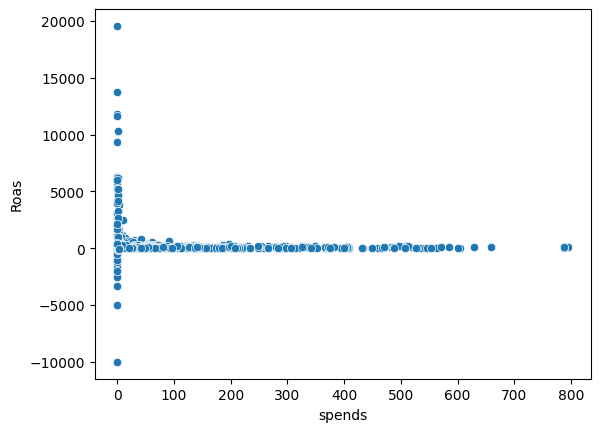

In [30]:
# Пострим график зависимости spends от ROAS
sns.scatterplot(x=effect.spends, y=effect.Roas)
plt.show()

In [31]:
# На графике длинные хвосты и выбросы, основная часть данных сконцентроирована в одном месте
# Зависимость сложная, будем решать с помощью ансамбля алгоритмов

In [32]:
# Отберем безубыточные кампании, по которым есть информация на 60й день
effect_plus = effect.loc[(effect['60d_LTV'] >= 0)]

In [33]:
# Импортируем библиотеки для построения модели
# Возьмём "Случайный лес", т.к.:
# 1. Хорошо распараллеливается
# 2. Для нелинейной зависимости
# 3. Хорошо справляется с выбросами
# 4. Решает проблему дисперсии
# Пункты 3 и 4 особенно актуальны для данной задачи, много выбросов и хвосты на графиках,
# так же визуально виден большой разброс данных

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

RAND=10

X = pd.DataFrame(effect_plus.spends)
y = pd.DataFrame(effect_plus.Roas)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=RAND)

In [34]:
# Универасльаная функция для проверки моделей на переобучение

def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting для регрессии
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [35]:
# Обучим модель, возьмем в качестве критерия устойчивую к выбросам среднюю абсолютную ошибку

rf = RandomForestRegressor(n_estimators = 50, max_depth=8, random_state=RAND, n_jobs=-1, criterion='absolute_error')

rf.fit(X_train, y_train)
check_overfitting(rf,
                  X_train_,
                  y_train_,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 134.865
mean_absolute_error test: 134.813
delta = 0.0 %


Получили практически идельную модель, непереобученную, которая хорошо предсказывает значение ROAS в зависимости от поданной на вход суммы spends.

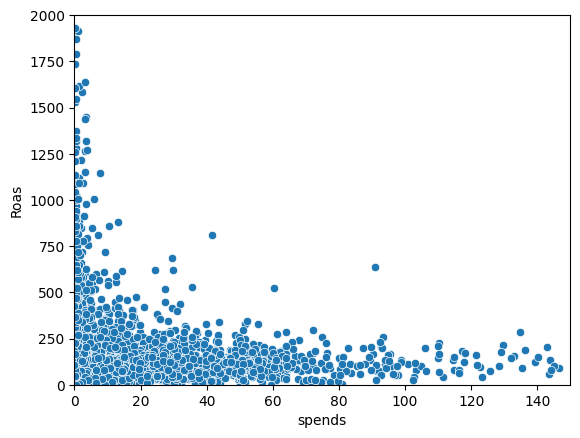

In [36]:
sns.scatterplot(x=effect_plus.spends, y=effect_plus.Roas)

# Для наглядности приблизим график с наибольшим скоплением данных
plt.ylim(0, 2000)
plt.xlim(0, 150)
plt.show()

График можно разделить примерно на 3 участка:<br>
    1. spends в интервале примерно[0,3] Здесь величина ROAS не зависит от суммы расходов, и может достигать более чем 800%. Трудно предсказать результат, он обусловлен случайностью.<br>
    2. spends в интервале примерно [3,80]. Здесь можно предположить только максимально возможное значение ROAS, т.к. данные расположены хаотично.<br>
    3. spends более 80. Независимо от суммы расходов, ROAS не превысит примерно 200-250%. Конкретный результат обусловлен случайностью.
<br>    
Таким образом, сумма расходов должна рассчитываться из максимально ожидаемого, необходимого ROAS.

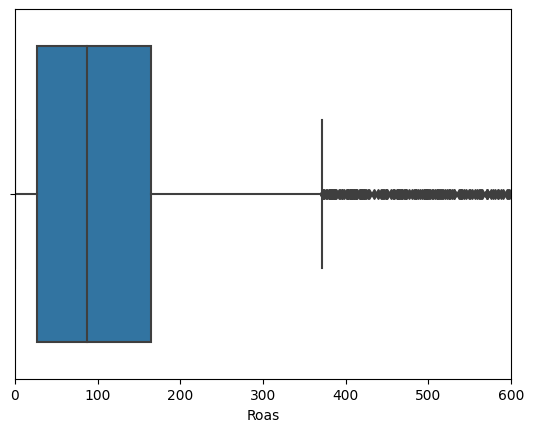

In [37]:
# Рассмотрим более подробно значения на боксплоте
sns.boxplot(x='Roas', data=effect_plus)
plt.xlim(0, 600)
plt.show()

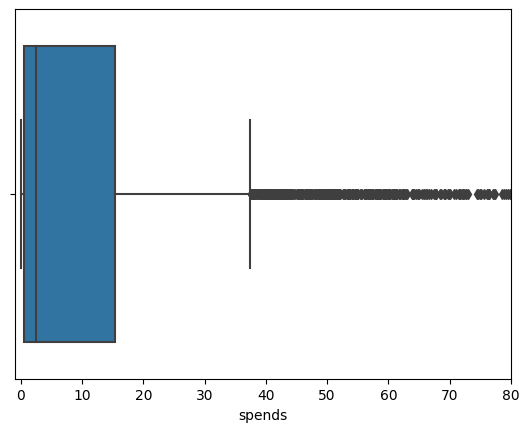

In [38]:
sns.boxplot(x='spends', data=effect_plus)
plt.xlim(-1, 80)
plt.show()

Медианное значение ROAS около 90% говорит о том, что примерно половина рекламных кампаний неэффективны. В то же время, для остальных кампаний  ROAS достигает 600% и более. Для эффективных кампаний ROAS чаще всего (около 20% всех кампаний) составлет 100-180%. Более высокие значения ROAS по эффективным кампаниям распределены неравномерно.
Сумма расходов в 75% случаев достигает 15. Более высокие суммы распределены так же неравномерно. <br>
Размах ROAS шире, чем spends, что может говорить о слабой зависимости эффекта кампании от расходов.
Исследуем далее.

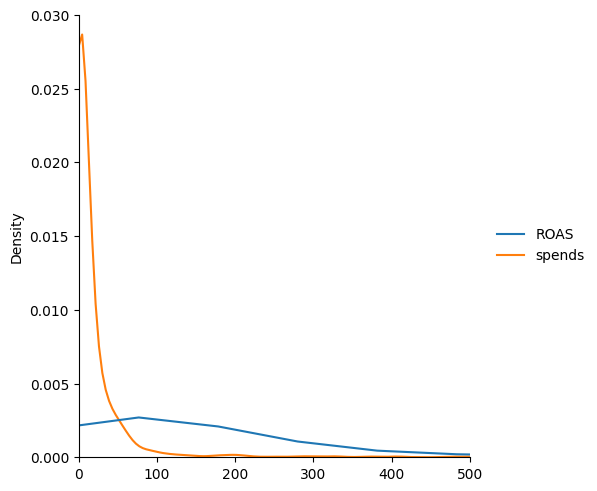

In [39]:
sns.displot({
        "ROAS": effect_plus.Roas,
        "spends": effect_plus.spends
    },
    common_norm=False,
    kind="kde",
    height=5)
plt.xlim(0, 500)
plt.ylim(0, 0.03)
plt.show()

Плотности вероятностей  ROAS и spends так же распределены неравномерно, у spends распределение Пуассона. Сложно сказать про зависимость.

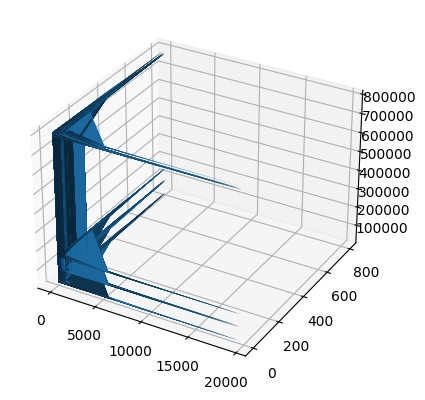

In [40]:
# Посмотрим на влияние исходов конкретных рекламных кампаний
from mpl_toolkits.mplot3d import Axes3D

x = effect_plus.Roas
y = effect_plus.spends
z = pd.DataFrame(effect_plus['campaign_id'])

def plot3d(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z)
    plt.show()
    
p = multiprocessing.Process(target=plot3d(x, y, z))
p.start()

Данное представление говорит о том, что много неэффективных рекламных компаний, по которым расходы достигали примерно 300, а ROAS оставался в окрестности 0. Эффективные кампании можно разделить на 4 группы. Необходим более детальный анализ причин как всплесков эффективности рекламных кампаний, так и причин отсутсвия эффекта.
<br> Одинаковым суммам расходов соответствуют разные суммы ROAS. Однако, разброс ROAS для каждой суммы расходов уменьшается по мере роста расходов. То есть, по мере роста расходов, уменьшается не ROAS, а максимальный ROAS, на который можно рассчитывать и легче спрогнозировать.

In [41]:
# Рассмотрим метрический алгоритм

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

sosed = KNeighborsRegressor(n_neighbors=4)
sc = MinMaxScaler()

X_train_std = sc.fit_transform(X_train)
X_train_std_ = sc.fit_transform(X_train_)
X_test_std = sc.transform(X_test)


sosed.fit(X_train_std, y_train)
check_overfitting(sosed,
                  X_train_std_,
                  y_train_,
                  X_test_std,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 173.339
mean_absolute_error test: 173.289
delta = 0.0 %


У метода ближайших соседей выше ошибка, чем у случайного леса, но здесь можно интерпретировать, что для каждой суммы расходов можно предсказать средний ожидаемый ROAS по четырём ближайшим суммам.

In [42]:
# Так как распределение данных ненормальное, применим непараметрические методы для проверки гиоптезы Н0 о том,
# что между COST и ROAS нет зависимости
stats.kendalltau(effect_plus['Roas'], effect_plus['spends'])

SignificanceResult(statistic=0.1912687179813937, pvalue=1.0878811348455314e-82)

In [43]:
stats.spearmanr(effect_plus['Roas'], effect_plus['spends'])

SignificanceResult(statistic=0.2785169415391974, pvalue=2.463465692676719e-82)

pvalue меньше уровня значимости 0,05, что говорит о значимости расчетов, но максимальное значение критериев достигает 0,28, что говорит об очень слабой связи, или её отсутсвии между признаками.
Не принимаем H0.<br>
Вывод: <b> Принимаем гитпотезу H1: между расходами и ROAS нет значимой связи, результат обусловлен случайностью или вероятностью. <br> <i><br>Но чем больше расходы, тем меньше максимльно возможное значение ROAS. </i><br>Дополнительно можно выделить моменты:<br></b>
    1. Если сумма расходов от 0 до 3, то величина ROAS не зависит от суммы расходов, и может достигать более чем 800%. Трудно предсказать результат, обусловлено случайностью. <br>
    2. Если сумма расходов от 3 до 80, то можно предположить только максимально возможное значение ROAS, т.к. данные распложены хаотично. Как вариант, использовать модели машинного обучения.<br>
    3. Если сумма расходов более 80, то независимо от суммы расходов, ROAS не превысит примерно 200-250%. Конкретный результат обусловлен случайностью или вероятностью. Так же можно использовать вероятностный подход, в том числе в машинном обучении.
<br>    
Таким образом, сумма расходов должна рассчитываться из максимально ожидаемного, необходимого ROAS, необходим вероятностный подход. <br>
Так же можно рассчитать ROAS для каждой суммы расходов при помощи использованной модели "Слуйчаный лес".

# 4.2 По каждой рекламной кампании рассчитайте суточный рекламный бюджет, который максимизирует абсолютную маркетинговую прибыль рекламной кампании (REVENUE 60 дня минус COST)

In [44]:
effect_plus['income'] = effect_plus['60d_LTV'] - effect_plus['spends']

In [45]:
day_cost = effect_plus.groupby(['campaign_id', 'Install_Dates']).agg({
    'spends':
    'sum',
    'income':
    'sum'
})

In [46]:
idx = day_cost.groupby('campaign_id')['income'].idxmax()
max_dailyincome = day_cost.loc[idx].reset_index()
# Результат в таблице, где максимально возможной суточной прибыли соответствует сумма расходов

# 4.3 Исходя из пункта 2 по каждой рекламной кампании дайте ваше заключение о том насколько нужно увеличить / уменьшить ее суточный бюджет либо вообще остановить.

Так как нет функции зависмости между доходами и расходми на рекламную кампанию, выполним расчеты по таблицам и графикам.

In [47]:
# Отберем безубыточные акции
max_dailyincome_plus = max_dailyincome.loc[(max_dailyincome['income'] > 0)]

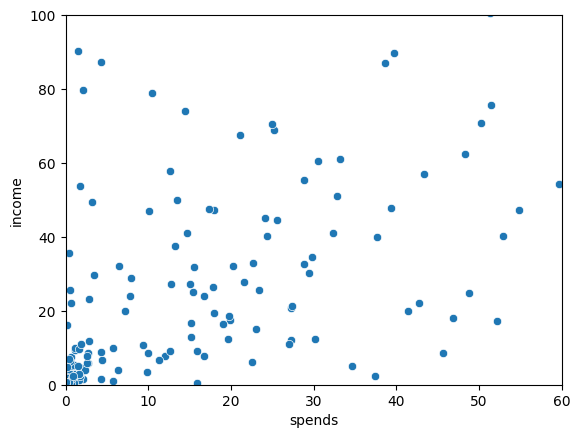

In [48]:
sns.scatterplot(x=max_dailyincome_plus.spends, y=max_dailyincome_plus.income)

# Для наглядности приблизим график
plt.ylim(0, 100)
plt.xlim(0, 60)
plt.show()

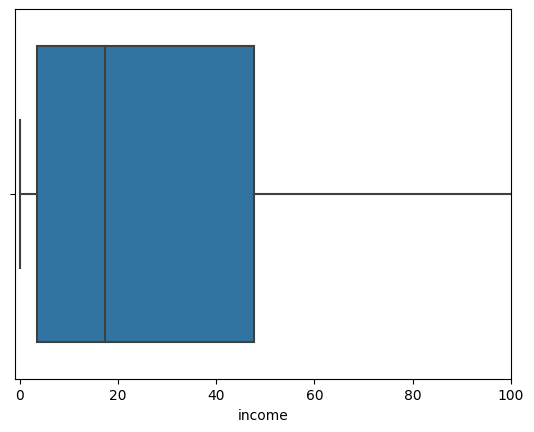

In [49]:
sns.boxplot(x='income', data=max_dailyincome_plus)
plt.xlim(-1, 100)
plt.show()

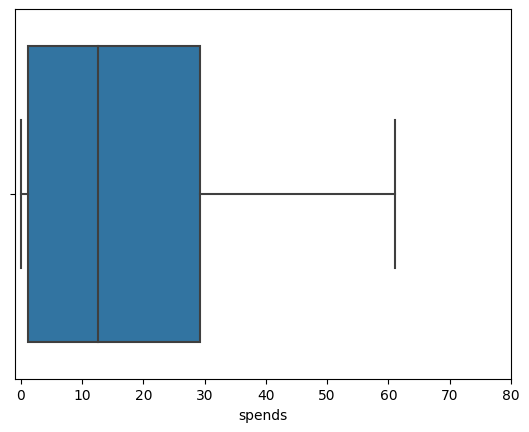

In [50]:
sns.boxplot(x='spends', data=max_dailyincome_plus)
plt.xlim(-1, 80)
plt.show()

In [51]:
# Отберем убыточные акции, посчитаем количество
max_dailyincome_min = max_dailyincome.loc[(max_dailyincome['income'] <= 0)]
max_dailyincome_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 14 to 200
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   campaign_id    27 non-null     int64  
 1   Install_Dates  27 non-null     object 
 2   spends         27 non-null     float64
 3   income         27 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.1+ KB


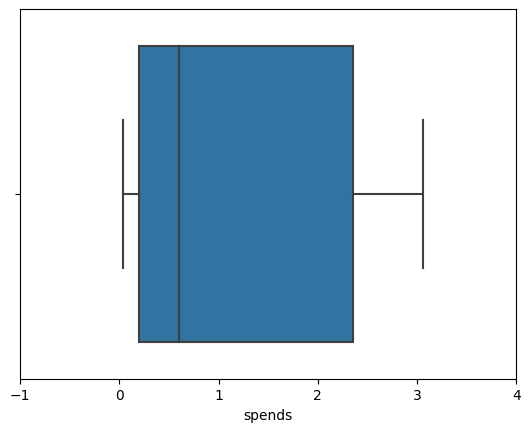

In [52]:
sns.boxplot(x='spends', data=max_dailyincome_min)
plt.xlim(-1, 4)
plt.show()

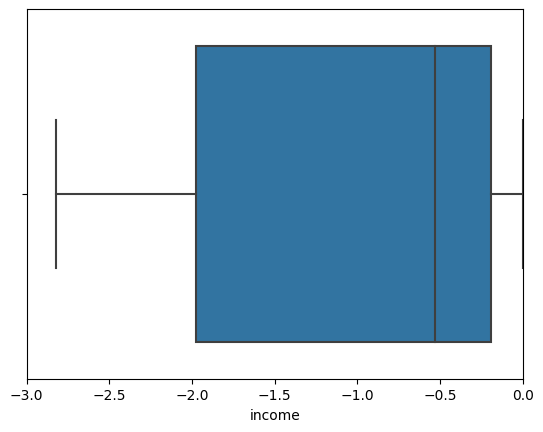

In [53]:
sns.boxplot(x='income', data=max_dailyincome_min)
plt.xlim(-3, 0)
plt.show()

Для 75% рекламных кампаний сумма дохода не превышает примерно 50. Явной зависимости между доходами и расходами нет. Рекомендуется, чтобы расходы не превышали 30, т.к. при росте доходов вероятность роста прибыли не меняется. Некритично, если нет возможности сократить расходы, так как убытка нет и вероятность получения конкретной суммы прибыли не изменится.<br>
По убыточным кампаниям рекомендуется увеличить сумму расходов до 3, т.к. от этой суммы и больше не наблюдается убытков.

# 4.4 Решите проблему рекламных кампаний по которым еще нет полных 60 дней. Объясните почему ваше решение оптимально

Отсутсвтующие значения для 60го дня можно предсказать, напрмер, с помощью линейной регрессии или регрессии случайный лес, ранее применимый к задаче 4.1.

In [54]:
# Отберем объекты, по которым есть информация на 60й день
effect_ = effect.loc[(effect['60d_LTV'] >= 0)]
effect_ = effect_.drop(columns=['Install_Dates', 'campaign_id', 'Country', 'installs', 'spends', 'Roas'])
effect_

,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV
0,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420
4,0.833442,0.833442,1.103046,1.167516,1.398647,1.416652
5,23.334978,39.280069,70.472199,77.112504,81.351981,84.733974
9,15.139952,18.056867,24.705458,30.279938,35.928758,43.839157
12,28.480374,34.615409,38.474778,40.865311,42.755548,45.331513
...,...,...,...,...,...,...
10198,0.277444,0.277444,0.277444,0.277444,0.277444,0.277444
10199,0.041716,0.041716,0.051738,0.060986,0.060986,0.060986
10201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10203,0.351962,0.351962,0.386234,0.448579,0.564261,0.693104


In [55]:
# Проверим распределение целевой переменной на возможность применения линейной регрессии
stats.shapiro(effect_['60d_LTV']).statistic

0.33725059032440186

Критерий выше 0,05, распределение близко к нормальному. Можем применить линейную регрессию.

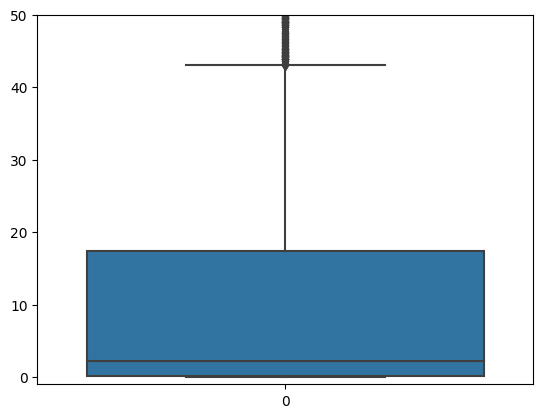

In [56]:
sns.boxplot(effect_['60d_LTV'])
plt.ylim(-1, 50)
plt.show()

In [57]:
X = effect_.drop(columns=['60d_LTV'],
            axis=1)

y = effect_['60d_LTV']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RAND)

In [59]:
# Обучим модели, возьмем в качестве критерия устойчивую к выбросам среднюю абсолютную ошибку

rf2 = RandomForestRegressor(n_estimators = 200, max_depth=4, random_state=RAND, n_jobs=-1, criterion='absolute_error')
rf2.fit(X_train, y_train)
check_overfitting(rf2,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 1.792
mean_absolute_error test: 1.758
delta = 1.9 %


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

lr = LinearRegression()

lr.fit(X_train, y_train)
check_overfitting(lr,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 1.264
mean_absolute_error test: 1.221
delta = 3.6 %


В целом, можно использовать любой из алгоритмов - "Слуйчайный лес" или "Линейная регрессия", т.к. у линейной регресси, несмотря на переобучение, меньше ошибка и более быстрый алгоритм, но у леса, несмотря на небольшое переобучение, больше ошибка.

In [61]:
pred = effect.loc[(effect['60d_LTV'] == -1)].drop(columns=['Install_Dates', 'campaign_id', 'Country', 'installs', 'spends', 'Roas', '60d_LTV'])
lv60 = lr.predict(pred)

# Выведем сравнительные описания массивов фактических и предсказанных значений 60го дня
# Пандас упорно не хотел принимать таблицы, кроме как завернутые в датафрейм :/
lv60 = pd.DataFrame(lv60, columns=['lin_pred'])

In [62]:
a = pd.DataFrame(lv60.describe())
b = pd.DataFrame(effect_['60d_LTV'].describe())

In [63]:
pd.concat([a, b], axis = 1)

,lin_pred,60d_LTV
count,5628.000000,4578.000000
mean,17.377744,22.495796
std,53.657482,66.883108
min,-0.098190,0.000000
25%,-0.037914,0.182784
50%,0.863017,2.181312
75%,11.120475,17.339793
max,884.975477,945.104897


Предсказания линейной регрессии в рамках допустимых значений, без аномалий.
Предположительно, сумма прогноза может быть занижена, но в данной задаче лучше допустить, что получим меньше выручки, чем допустить, что получим больше и недополучить. К тому же в датасете с уже имеющимися данными есть выбросы, которые искажают усредненную картину в лучшую сторону.

# 5. Связь рекламного траффика и органического

In [64]:
df = pd.read_csv('source_comparison.csv')
df.head()

,Install_Dates,source_type,Country,installs
0,2020-05-18,Paid,PY,4
1,2020-04-14,Paid,FR,35
2,2020-04-30,Paid,JP,25
3,2020-03-20,Paid,DE,11
4,2020-04-30,Paid,IT,8


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18606 entries, 0 to 18605
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Install_Dates  18606 non-null  object
 1   source_type    18606 non-null  object
 2   Country        18606 non-null  object
 3   installs       18606 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 581.6+ KB


# Гипотеза маркетологов: <br>Когда маркетологи привлекают больше рекламного траффика, растет и органический.

Гипотезу лучше переформулировать как Н0: Между притоком рекламного и органического трафика нет значимой зависимости. <br>
Альтенативная Н1: Приток рекламного и органического трафика взаимосвязаны.

In [66]:
# Создадим сводную таблицу для расчетов и построим график
df_pivot = pd.pivot_table(df,
                          index="Install_Dates",
                          values="installs",
                          columns="source_type",
                          aggfunc='sum').reset_index()

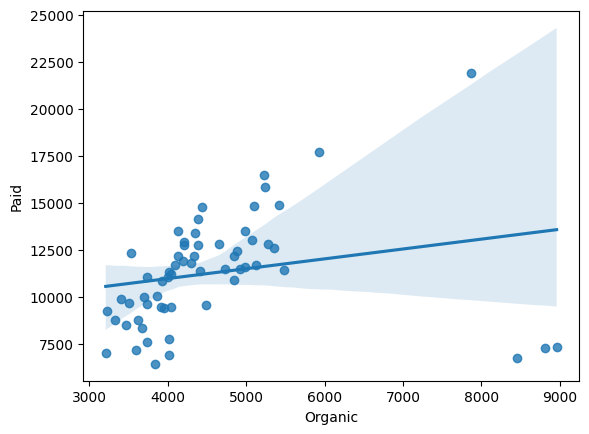

In [67]:
sns.regplot(x=df_pivot.Organic, y=df_pivot.Paid)
plt.show()

In [68]:
# Уберем 4 выброса из таблицы, построим новый график
df_pivot = df_pivot.sort_values(by='Organic', ascending=False).iloc[4:]

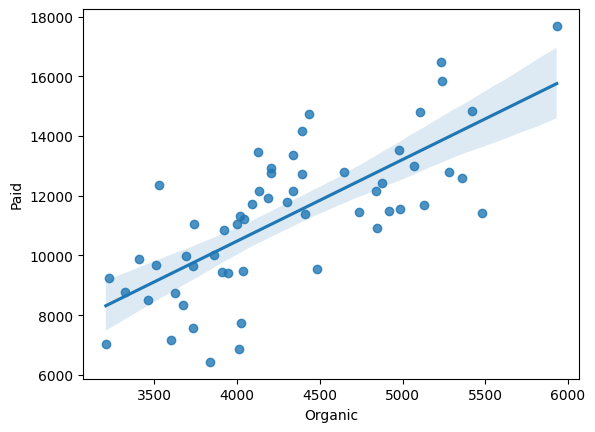

In [69]:
sns.regplot(x=df_pivot.Organic, y=df_pivot.Paid)
plt.show()

Визуально прослеживается некоторая зависимость.

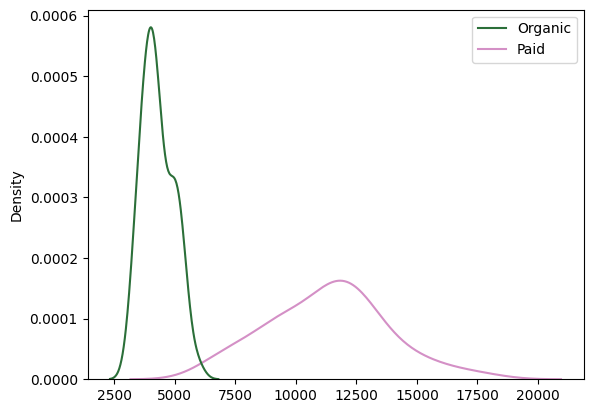

In [70]:
sns.kdeplot(data={
        "Organic": df_pivot.Organic,
        "Paid": df_pivot.Paid
    },
    common_norm=False,
    palette = 'cubehelix')
plt.show()

Распределения похожи на нормальные, обязательно проверим расчетным методом.

In [71]:
stats.shapiro(df_pivot['Paid']).statistic

0.9846438765525818

In [72]:
stats.shapiro(df_pivot['Organic']).statistic

0.9656698107719421

Оба распределения нормальные, критерий Шапиро-Уилка больше уровня значимости 0,05, можно применить критерий Пирсона.

In [73]:
stats.pearsonr(df_pivot['Organic'], df_pivot['Paid']).statistic

0.7314551753335484

Отвергаем гипотезу Н0 о независимости рекламного и органического траффика, принимаем альтернативную гипотезу Н1 о наличии связи, т.к. коэффициент корреляции Спирмена = 0.73, что говорит о явной линейной зависимости двух наблюдаемых признаков. Но расчет не дает информацию о том, какая переменная зависимая. То есть, без знания бизнес-процессов нельзя утверждать, зависит рекламный трафик от органического, или наоборот.
<br><b> Если есть наблюдения в бизнесе, что рекламный трафик приносит органический, то гипотеза макетолов верна - чем больше рекламного трафика, тем больше орагнического.